# Proyek Klasifikasi Gambar: [Input Nama Dataset]
- **Nama:** Junianto Endra Kartika
- **Email:** endra.kartika.25@gmail.com
- **ID Dicoding:** j3ndra21

## Import Semua Packages/Library yang Digunakan

In [4]:
import kagglehub

import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

## Data Preparation

### Data Loading

In [2]:
path = kagglehub.dataset_download("alessiocorrado99/animals10")

print("Path to dataset files:", path)

100%|██████████| 586M/586M [00:15<00:00, 38.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2


In [18]:
dataset_dir = '/root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2/raw-img'
image_size = (224, 224)
batch_size = 32

In [19]:
def count_images_recursive(directory, extensions=('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
    total_images = 0
    # os.walk traverses all subdirectories
    for root, dirs, files in os.walk(directory):
        # Filter files that match common image extensions
        image_files = [file for file in files if file.lower().endswith(extensions)]
        total_images += len(image_files)
    return total_images

total = count_images_recursive(dataset_dir)
print("Total images in the dataset:", total)

Total images in the dataset: 26179


### Data Preprocessing

#### Split Dataset

In [20]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split = 0.2)

In [21]:
train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='training'
)

test_generator = test_datagen.flow_from_directory(
    dataset_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation'
)

Found 20947 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.


## Modelling

In [22]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                              include_top=False,
                              weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [23]:
model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [24]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 5, 5, 32)            │         368,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,662,250 (10.16 MB)

 Trainable params: 404,266 (1.54 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [26]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)

In [28]:
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=test_generator,
    callbacks=[early_stopping, lr_reduction],
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 90s 116ms/step - accuracy: 0.7543 - loss: 0.8220 - val_accuracy: 0.9201 - val_loss: 0.2882 - learning_rate: 0.0010
Epoch 2/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 63s 96ms/step - accuracy: 0.8856 - loss: 0.4046 - val_accuracy: 0.9373 - val_loss: 0.2298 - learning_rate: 0.0010
Epoch 3/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 80s 94ms/step - accuracy: 0.8957 - loss: 0.3565 - val_accuracy: 0.9383 - val_loss: 0.2528 - learning_rate: 0.0010
Epoch 4/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 84s 96ms/step - accuracy: 0.9075 - loss: 0.3254 - val_accuracy: 0.9350 - val_loss: 0.2692 - learning_rate: 0.0010
Epoch 5/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9166 - loss: 0.2830
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
655/655 ━━━━━━━━━━━━━━━━━━━━ 64s 98ms/step - accuracy: 0.9166 - loss: 0.2830 - val_accuracy: 0.9381 - val_loss: 0.2588 - learning_rate: 0.0010
Epoch 6/100
655/655 ━━━━━━━━━━━━━━━━━━━━ 66s 100ms/step - accuracy: 0.93

In [29]:
history_df = pd.DataFrame(history.history)
history_df.to_csv('/content/history.csv', index=False)

## Evaluasi dan Visualisasi

In [32]:
if early_stopping.stopped_epoch > 0:
    stop_epoch = early_stopping.stopped_epoch - 5
else:
    stop_epoch = len(history.history['loss']) - 1  # Last epoch index

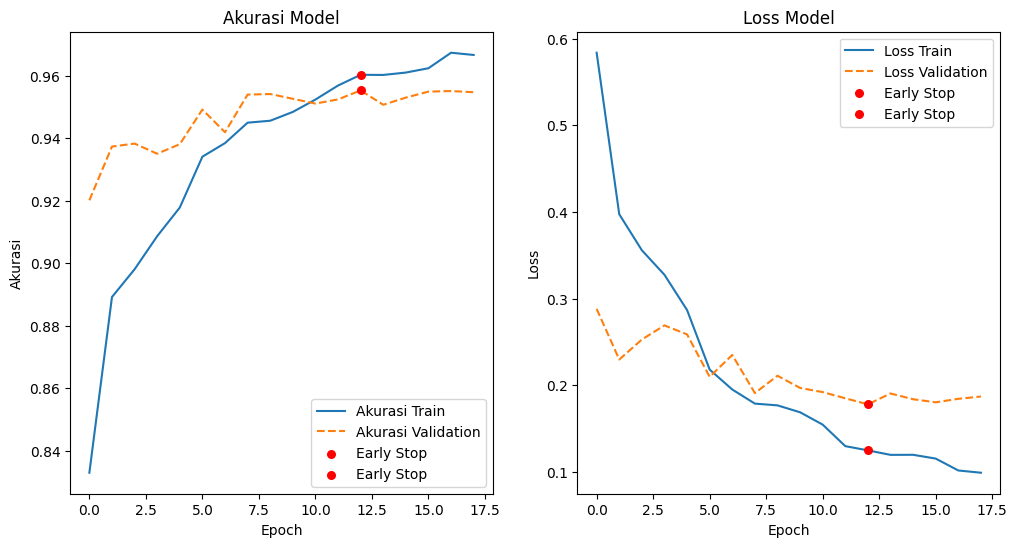

In [36]:
# Create the plots
plt.figure(figsize=(12, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Akurasi Train')
plt.plot(history.history['val_accuracy'], label='Akurasi Validation', linestyle='--')
# Add a red dot at the stopping epoch on the validation accuracy curve
plt.scatter(stop_epoch, history.history['accuracy'][stop_epoch], color='red', s=30, zorder=5, label='Early Stop')
plt.scatter(stop_epoch, history.history['val_accuracy'][stop_epoch], color='red', s=30, zorder=5, label='Early Stop')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss Train')
plt.plot(history.history['val_loss'], label='Loss Validation', linestyle='--')
# Add a red dot at the stopping epoch on the validation loss curve
plt.scatter(stop_epoch, history.history['loss'][stop_epoch], color='red', s=30, zorder=5, label='Early Stop')
plt.scatter(stop_epoch, history.history['val_loss'][stop_epoch], color='red', s=30, zorder=5, label='Early Stop')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [37]:
plt.savefig('model_plot.png', dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

In [38]:
true_classes = []
predicted_classes = []

for images, labels in test_generator:
    predictions = model.predict(images)
    predicted_classes_batch = np.argmax(predictions, axis=1)

    true_classes.extend(labels)
    predicted_classes.extend(predicted_classes_batch)

    if len(true_classes) >= test_generator.samples:
        break

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━

In [52]:
translate = {
    "cane": "dog",
    "cavallo": "horse",
    "elefante": "elephant",
    "farfalla": "butterfly",
    "gallina": "chicken",
    "gatto": "cat",
    "mucca": "cow",
    "pecora": "sheep",
    "scoiattolo": "squirrel",
    "dog": "cane",
    "elephant": "elefante",
    "butterfly": "farfalla",
    "chicken": "gallina",
    "cat": "gatto",
    "cow": "mucca",
    "spider": "ragno",
    "squirrel": "scoiattolo"
}

In [53]:
original_labels = [label for label, idx in sorted(train_generator.class_indices.items(), key=lambda item: item[1])]
translated_labels = [translate.get(label, label) for label in original_labels]

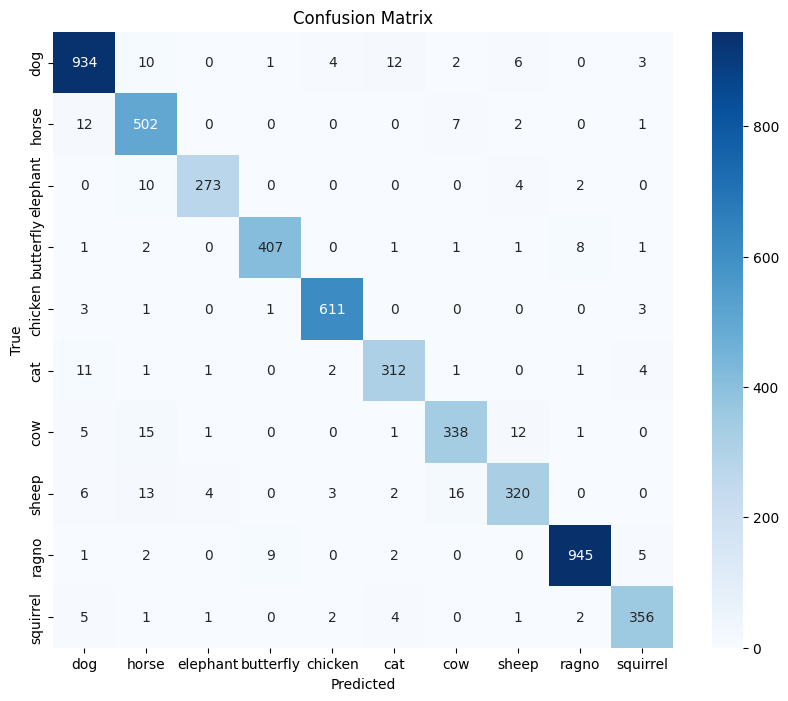

In [54]:
# Create confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=translated_labels, yticklabels=translated_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [58]:
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=list(translated_labels)))

Classification Report:
              precision    recall  f1-score   support

         dog       0.96      0.96      0.96       972
       horse       0.90      0.96      0.93       524
    elephant       0.97      0.94      0.96       289
   butterfly       0.97      0.96      0.97       422
     chicken       0.98      0.99      0.98       619
         cat       0.93      0.94      0.94       333
         cow       0.93      0.91      0.92       373
       sheep       0.92      0.88      0.90       364
       ragno       0.99      0.98      0.98       964
    squirrel       0.95      0.96      0.96       372

    accuracy                           0.96      5232
   macro avg       0.95      0.95      0.95      5232
weighted avg       0.96      0.96      0.96      5232



In [56]:
# Evaluate on the training data
train_loss, train_accuracy = model.evaluate(train_generator, verbose=0)
print("Training Accuracy:", train_accuracy)

# Evaluate on the validation/test data
test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print("Validation/Test Accuracy:", test_accuracy)

Training Accuracy: 0.9838640093803406
Validation/Test Accuracy: 0.9552752375602722


## Konversi Model

In [44]:
model.save("/content/my_model.keras")

In [45]:
model.export('/content/saved_model')

Saved artifact at '/content/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  133697675705040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133697675706192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133697675705616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133697675706000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133697675705424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133697675705232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133697620476944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133697620476176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133697620477328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133697620477520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13369

In [59]:
# Ensure the directory exists
tflite_dir = "/content/tflite"
os.makedirs(tflite_dir, exist_ok=True)

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model('/content/saved_model')
tflite_model = converter.convert()

# Save the TFLite model
tflite_model_path = os.path.join(tflite_dir, "model.tflite")
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

# Save the label file (if needed)
class_names = sorted(translated_labels)
with open("/content/tflite/label.txt", "w") as f:
    for label in class_names:
        f.write(f"{label}\n")

In [43]:
!pip install -q tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 90.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 36.1 MB/s eta 0:00:00


In [47]:
import tensorflowjs as tfjs

tfjs_target_dir = "/content/tfjs_model"
tfjs.converters.save_keras_model(model, tfjs_target_dir)

failed to lookup keras version from the file,
    this is likely a weight only file


In [48]:
from google.colab import files

In [60]:
!zip -r /content/file.zip /content

updating: content/ (stored 0%)
updating: content/.config/ (stored 0%)
updating: content/.config/config_sentinel (stored 0%)
updating: content/.config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db (deflated 97%)
updating: content/.config/.last_update_check.json (deflated 22%)
updating: content/.config/.last_survey_prompt.yaml (stored 0%)
updating: content/.config/gce (stored 0%)
updating: content/.config/configurations/ (stored 0%)
updating: content/.config/configurations/config_default (deflated 15%)
updating: content/.config/default_configs.db (deflated 98%)
updating: content/.config/active_config (stored 0%)
updating: content/.config/logs/ (stored 0%)
updating: content/.config/logs/2025.02.06/ (stored 0%)
updating: content/.config/logs/2025.02.06/14.18.56.503663.log (deflated 58%)
updating: content/.config/logs/2025.02.06/14.19.04.384852.log (deflated 57%)
updating: content/.config/logs/2025.02.06/14.19.05.026938.log (deflated 57%)
updating: content/.config/logs/2025

In [61]:
files.download("/content/file.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference (Optional)

In [62]:
image_size = (224, 224)
test_folder = '/content/test_data/'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
File: Holstein-cow.jpg --> Predicted class: cow with confidence: 0.98


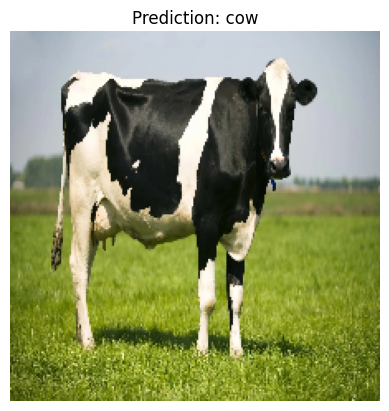

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
File: sheep-animals-idalGettyImages0702F2-3518_0_0.jpg --> Predicted class: sheep with confidence: 1.00


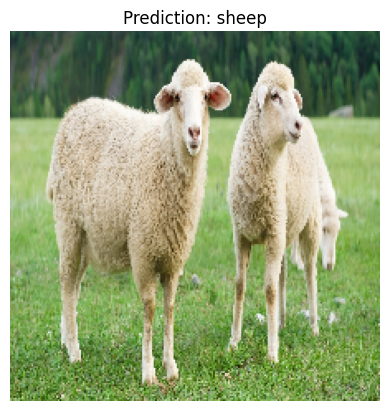

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
File: pexels-photo-6696645.jpeg --> Predicted class: horse with confidence: 0.97


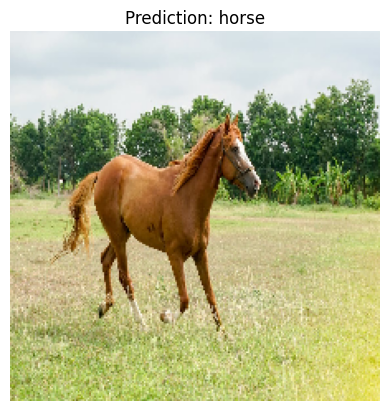

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
File: Male_and_female_chicken_sitting_together.jpg --> Predicted class: chicken with confidence: 1.00


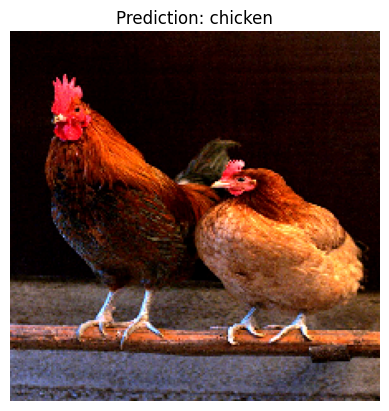

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
File: EasternGraySquirrel_GAm.jpg --> Predicted class: squirrel with confidence: 1.00


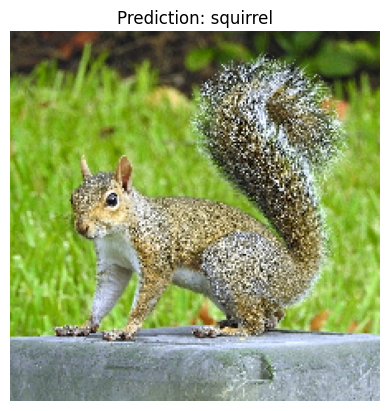

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
File: Lime-butterfly-Papilio-demoleus-feeding-on-flower.jpg --> Predicted class: butterfly with confidence: 1.00


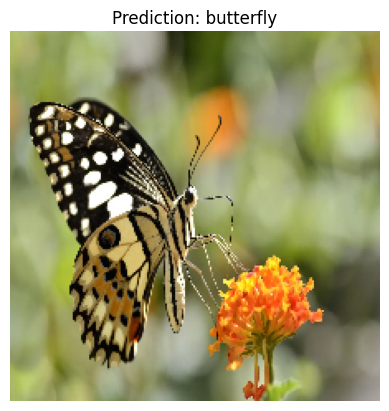

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
File: cbf37398-601d-48a2-bf3e-2b3dff88be75.jpg --> Predicted class: ragno with confidence: 1.00


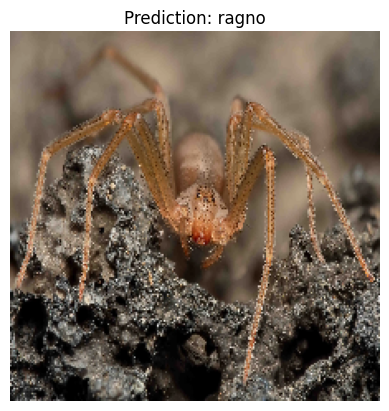

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
File: michael-sum-LEpfefQf4rU-unsplash.jpg --> Predicted class: cat with confidence: 1.00


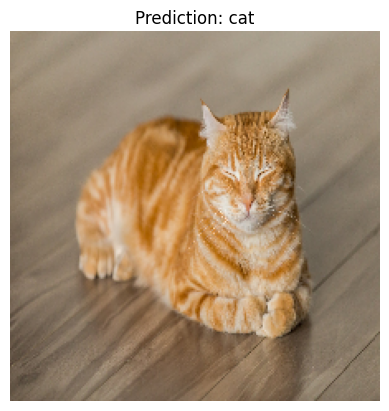

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
File: German-Shepherd-dog-Alsatian.jpg --> Predicted class: dog with confidence: 1.00


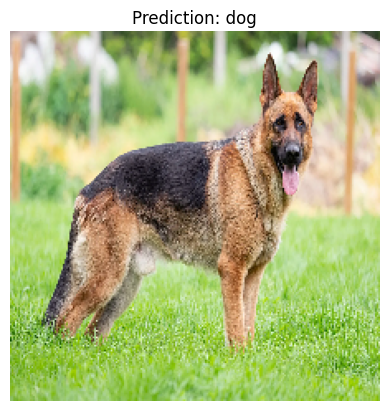

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
File: African-Elephant-1-1024x768.jpg --> Predicted class: elephant with confidence: 1.00


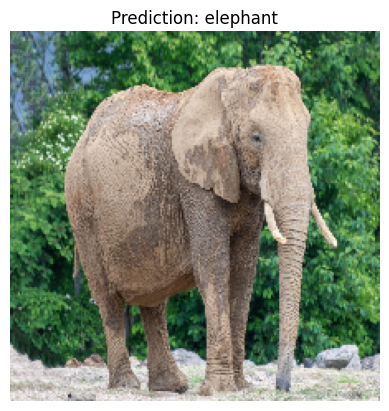

In [67]:
for filename in os.listdir(test_folder):
    # Check if the file is an image (you can add more extensions if needed)
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        file_path = os.path.join(test_folder, filename)

        # Load the image and resize it to match your model's input size
        img = tf.keras.preprocessing.image.load_img(file_path, target_size=image_size)

        # Convert the image to an array
        img_array = tf.keras.preprocessing.image.img_to_array(img)

        # Normalize the image (since your training used rescaling)
        img_array /= 255.0

        # Add an extra dimension to simulate a batch of size 1
        img_array = np.expand_dims(img_array, axis=0)

        # Make a prediction using your trained model
        prediction = model.predict(img_array)
        predicted_class = np.argmax(prediction, axis=1)[0]

        # Retrieve the label (if available)
        predicted_label = translated_labels[predicted_class]
        confidence = prediction[0][predicted_class]

        # Print and optionally display the result
        print(f"File: {filename} --> Predicted class: {predicted_label} with confidence: {confidence:.2f}")

        plt.imshow(img)
        plt.title(f"Prediction: {predicted_label}")
        plt.axis('off')
        plt.show()